# Grad-CAM Implementation - XAI Project

### Introduction

In the rapidly evolving field of artificial intelligence, we often encounter models that are considered **"black boxes"** due to their complex internal mechanisms. While these models can produce highly accurate predictions, understanding the reasoning behind these predictions remains a challenge. This project aims to address this issue in the context of brain tumor image classification.

### Project Overview

In this project, we will be developing a **Convolutional Neural Network (CNN)** that can accurately classify brain tumor images. We will be utilizing three state-of-the-art pre-trained models:

1. **VGG16**
2. **ResNet50**
3. **DenseNet121**

These models have been selected due to their exceptional performance in image classification tasks. By using these pre-trained models, we can leverage their learned feature representations, thereby saving significant computational resources and time.


#### **Explainability**

To demystify our models, we will be employing **Grad-CAM (Gradient-weighted Class Activation Mapping)**. Grad-CAM uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

### Importance of the Project

- The project has the potential to contribute significantly to the field of **medical imaging and diagnosis**.
  - **Brain tumor**s are a serious health concern, and early detection can lead to improved patient outcomes.
- 
The development of a model that can accurately classify brain tumor images and explain its predictions can provide valuable insights to healthcare professionals
- .
This could potentially lead **to more accurate diagno**ses and a better understanding of these complex diseas

- s.
The use of explainable AI in this project highlights the importance** of transparency and interpretabi**lity in machine learning mode
- ls.
As AI continues to advance in various fields, it becomes increasingly crucial to ensure that these models are understandable and justifiable.

### Load necessary libraries

In [6]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Classes
- The name of the classes of brain tumors used in the dataset

In [4]:
class_names = pd.DataFrame(os.listdir('./brain tumor/Training'), columns = ['Brain Tumors'])
class_names

Brain Tumors
0       glioma
1   meningioma
2      notumor
3    pituitary

## Data Generator

In [8]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory('./brain tumor/Training',  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')  

validation_generator = datagen.flow_from_directory('./brain tumor/Training',  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='validation')  

test_generator = datagen.flow_from_directory('./brain tumor/Testing',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

Found 4413 images belonging to 4 classes.
Found 777 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## ConvNet Model (Pretrained VGG-16)
* Finetune the entire network
* Imagenet contains various images, so the network has already learnt features related to other images
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Custom Model Structure

1. **Base Model (VGG16)**:
   - We initialize the VGG16 model with pre-trained weights from ImageNet. We exclude the top layers (fully connected layers) as we will be adding our own. The input shape is set to the size of our images.

2. **Adding Custom Layers**:
   - We use the output from the second last layer of the base model and add a **Global Average Pooling 2D** layer. This is followed by a **Dense layer** with **512 neurons** and **‘relu’** activation function. The final layer is a **Dense layer with 4 neurons** (corresponding to our 4 classes) and **‘softmax’** activation function.

3. **Optimizer**:
   - Adam Optimizer, adjusts the learning rate adaptively for each parameter.

4. **Learning Rate**:
   - 0.0001, slow and steady

### Model Definition and Hyperparameter Settings

In [9]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

#Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 3 successive epochs
- Stop the training if the validation loss does not decrease after 5 successive epochs
- Save the best model if it has a better validation loss than before

In [5]:
model_name = "brain tumor.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=0)

earlystopping = EarlyStopping(monitor='val_loss', 
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1, 
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.2, 
                                            min_lr = 0.00000001)

### Model Training

In [6]:
history = model.fit(train_generator,
                    epochs = 15,
                    batch_size = 1,
                    validation_data = validation_generator,
                    callbacks = [checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/15
138/138 [==============================] - 94s 577ms/step - loss: 1.2880 - accuracy: 0.4904 - val_loss: 1.2040 - val_accuracy: 0.5663 - lr: 1.0000e-04
Epoch 2/15
138/138 [==============================] - 54s 393ms/step - loss: 1.0684 - accuracy: 0.6746 - val_loss: 1.0703 - val_accuracy: 0.6306 - lr: 1.0000e-04
Epoch 3/15
138/138 [==============================] - 53s 383ms/step - loss: 0.9151 - accuracy: 0.7278 - val_loss: 0.9670 - val_accuracy: 0.6461 - lr: 1.0000e-04
Epoch 4/15
138/138 [==============================] - 53s 382ms/step - loss: 0.8189 - accuracy: 0.7376 - val_loss: 0.8987 - val_accuracy: 0.6692 - lr: 1.0000e-04
Epoch 5/15
138/138 [==============================] - 52s 377ms/step - loss: 0.7504 - accuracy: 0.7482 - val_loss: 0.8569 - val_accuracy: 0.6873 - lr: 1.0000e-04
Epoch 6/15
138/138 [==============================] - 53s 382ms/step - loss: 0.6886 - accuracy: 0.7729 - val_loss: 0.8325 - val_accuracy: 0.6847 - lr: 1.0000e-04
Epoch 7/15
138/138 [========

### Learning Curves

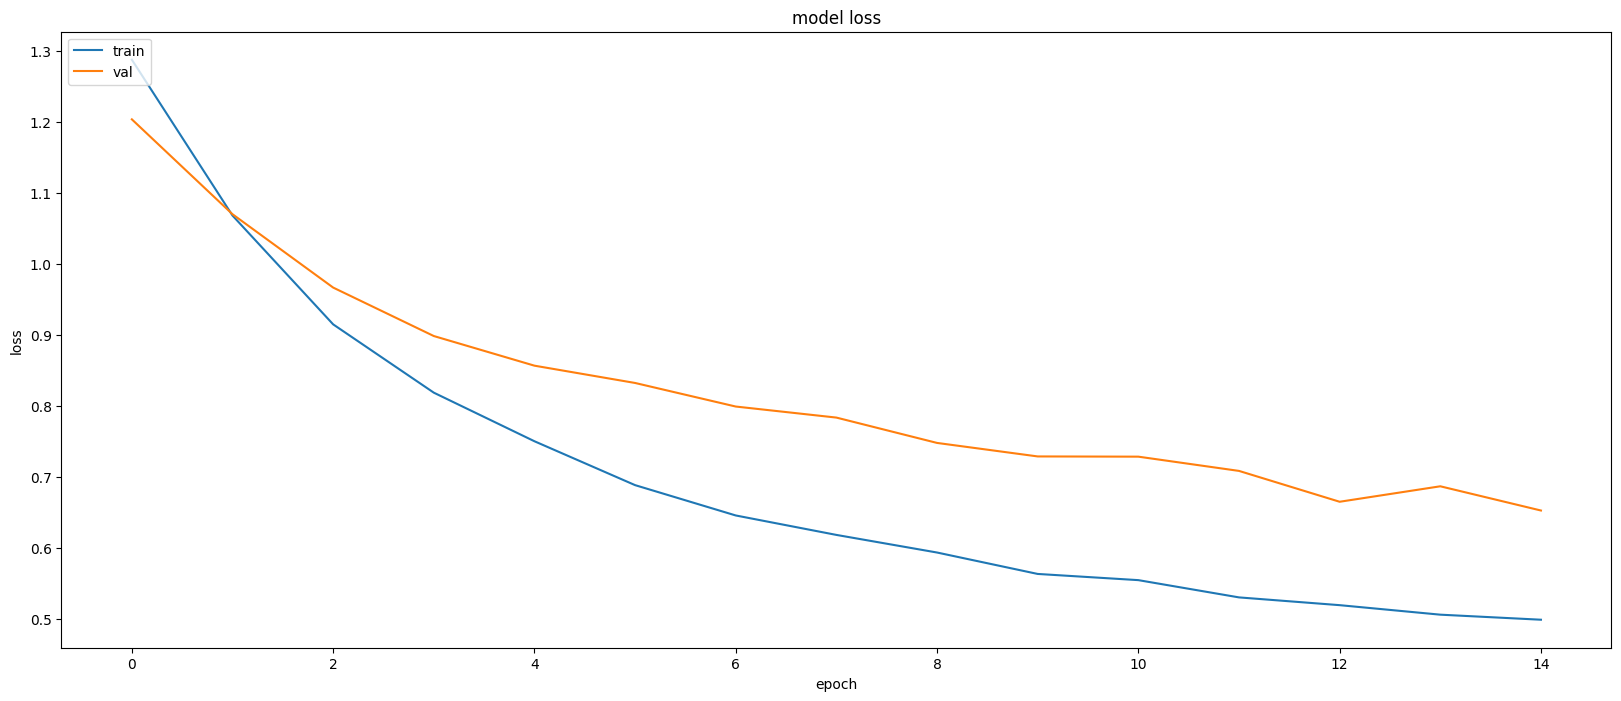

In [7]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

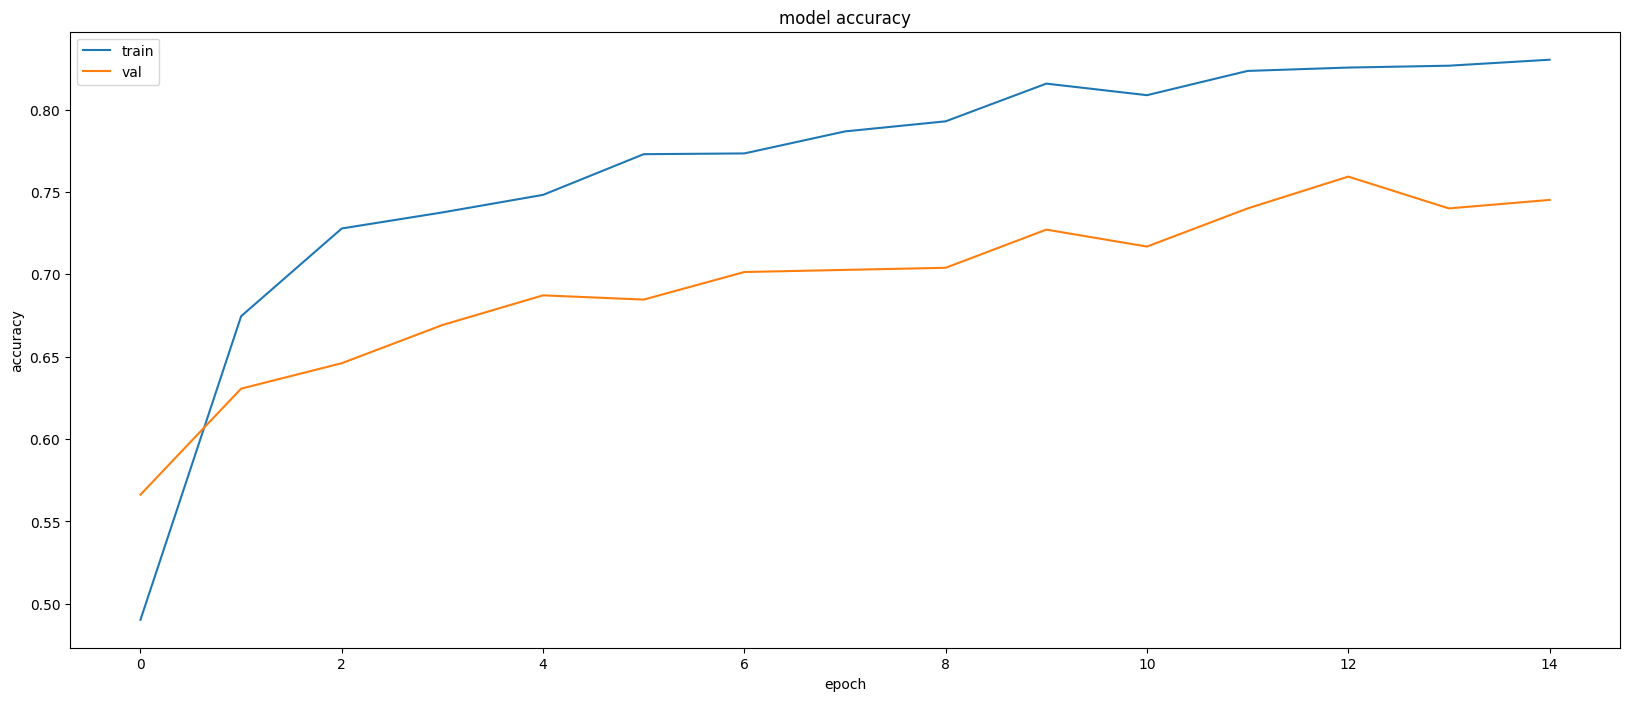

In [8]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Evalutation

In [9]:
from sklearn.metrics import classification_report

In [10]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

25/25 [==============================] - 8s 323ms/step


#### Classification Report

In [11]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.29      0.28       198
           1       0.27      0.24      0.26       200
           2       0.27      0.21      0.24       201
           3       0.25      0.33      0.29       178

    accuracy                           0.27       777
   macro avg       0.27      0.27      0.27       777
weighted avg       0.27      0.27      0.26       777



#### Check using table

In [12]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [13]:
filenames = validation_generator.filenames

In [15]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(30)

filename  actual   predicted   Same
0   glioma\Tr-glTr_0000.jpg  glioma   pituitary  False
1   glioma\Tr-glTr_0001.jpg  glioma   pituitary  False
2   glioma\Tr-glTr_0002.jpg  glioma  meningioma  False
3   glioma\Tr-glTr_0003.jpg  glioma  meningioma  False
4   glioma\Tr-glTr_0004.jpg  glioma  meningioma  False
5   glioma\Tr-glTr_0005.jpg  glioma  meningioma  False
6   glioma\Tr-glTr_0006.jpg  glioma      glioma   True
7   glioma\Tr-glTr_0007.jpg  glioma   pituitary  False
8   glioma\Tr-glTr_0008.jpg  glioma   pituitary  False
9   glioma\Tr-glTr_0009.jpg  glioma      glioma   True
10    glioma\Tr-gl_0010.jpg  glioma     notumor  False
11    glioma\Tr-gl_0011.jpg  glioma   pituitary  False
12    glioma\Tr-gl_0012.jpg  glioma   pituitary  False
13    glioma\Tr-gl_0013.jpg  glioma  meningioma  False
14    glioma\Tr-gl_0014.jpg  glioma      glioma   True
15    glioma\Tr-gl_0015.jpg  glioma   pituitary  False
16    glioma\Tr-gl_0016.jpg  glioma  meningioma  False
17    glioma\Tr-gl_0017.jpg  glioma   pituitary  False
18    glioma\Tr-gl_0018.jpg  glioma  meningioma  False
19    glioma\Tr-gl_0019.jpg  glioma      glioma   True
20    glioma\Tr-gl_0020.jpg  glioma   pituitary  False
21    glioma\Tr-gl_0021.jpg  glioma  meningioma  False
22    glioma\Tr-gl_0022.jpg  glioma  meningioma  False
23    glioma\Tr-gl_0023.jpg  glioma      glioma   True
24    glioma\Tr-gl_0024.jpg  glioma      glioma   True
25    glioma\Tr-gl_0025.jpg  glioma      glioma   True
26    glioma\Tr-gl_0026.jpg  glioma     notumor  False
27    glioma\Tr-gl_0027.jpg  glioma     notumor  False
28    glioma\Tr-gl_0028.jpg  glioma  meningioma  False
29    glioma\Tr-gl_0029.jpg  glioma     notumor  False

In [16]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

### Grad-CAM Implementation
* Understand which part of your images play a role in the final activation of a class
* Project the important spatial features of your input images and analyse what can be changed to improve the classifier's performance

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [18]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"./brain tumor/Training/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

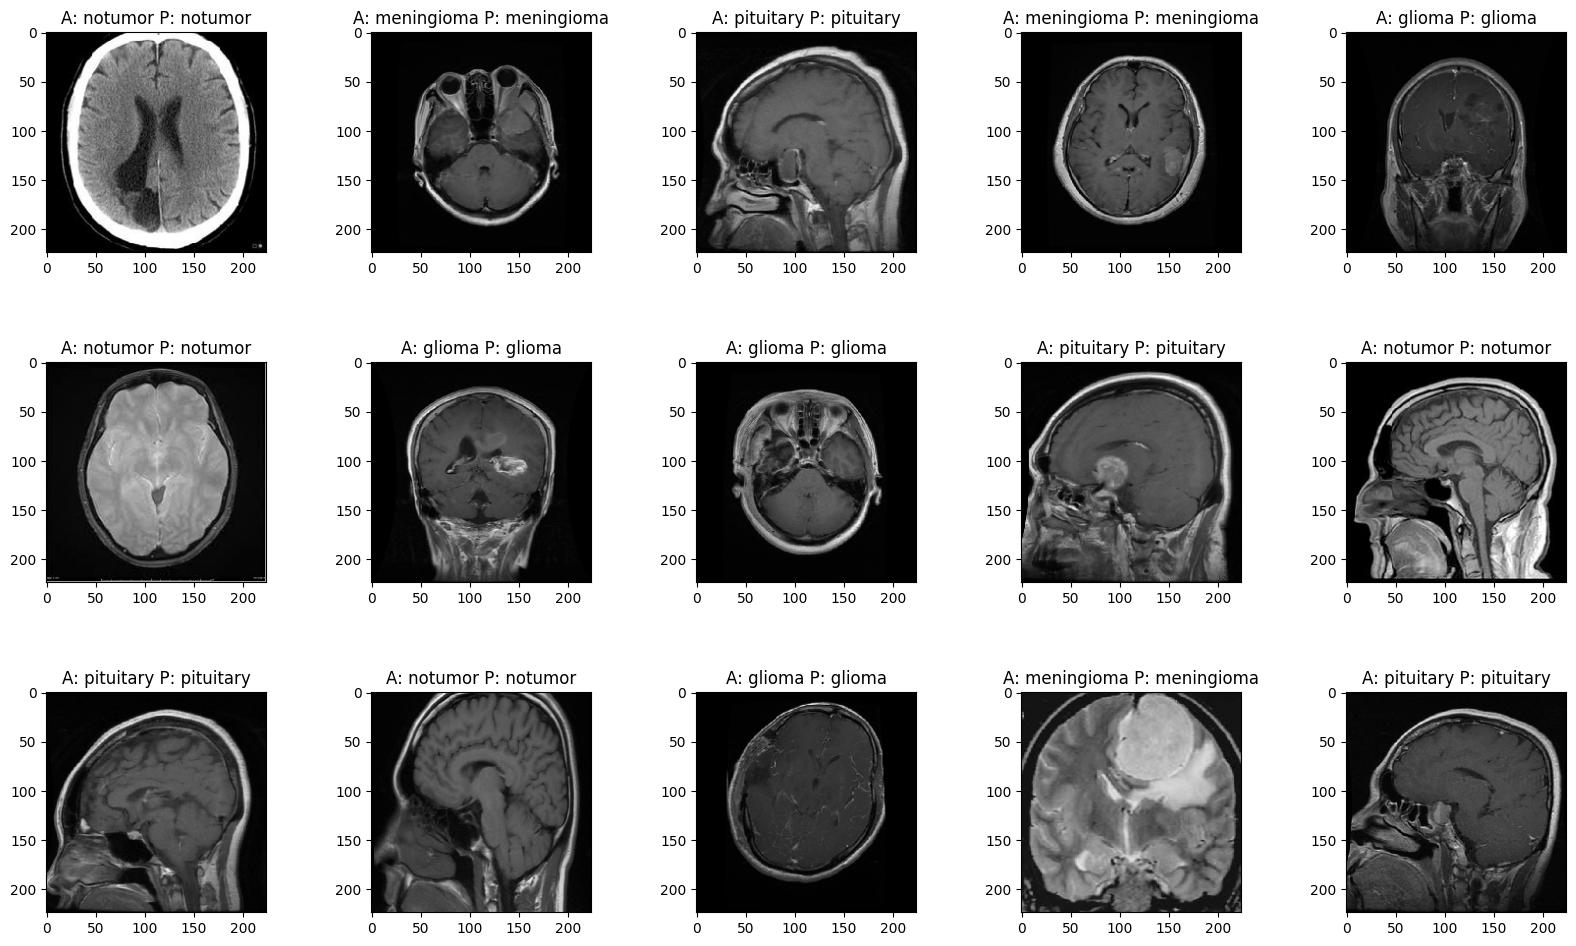

In [19]:
display_images(val_df[val_df['Same']==True])

### Misclassified

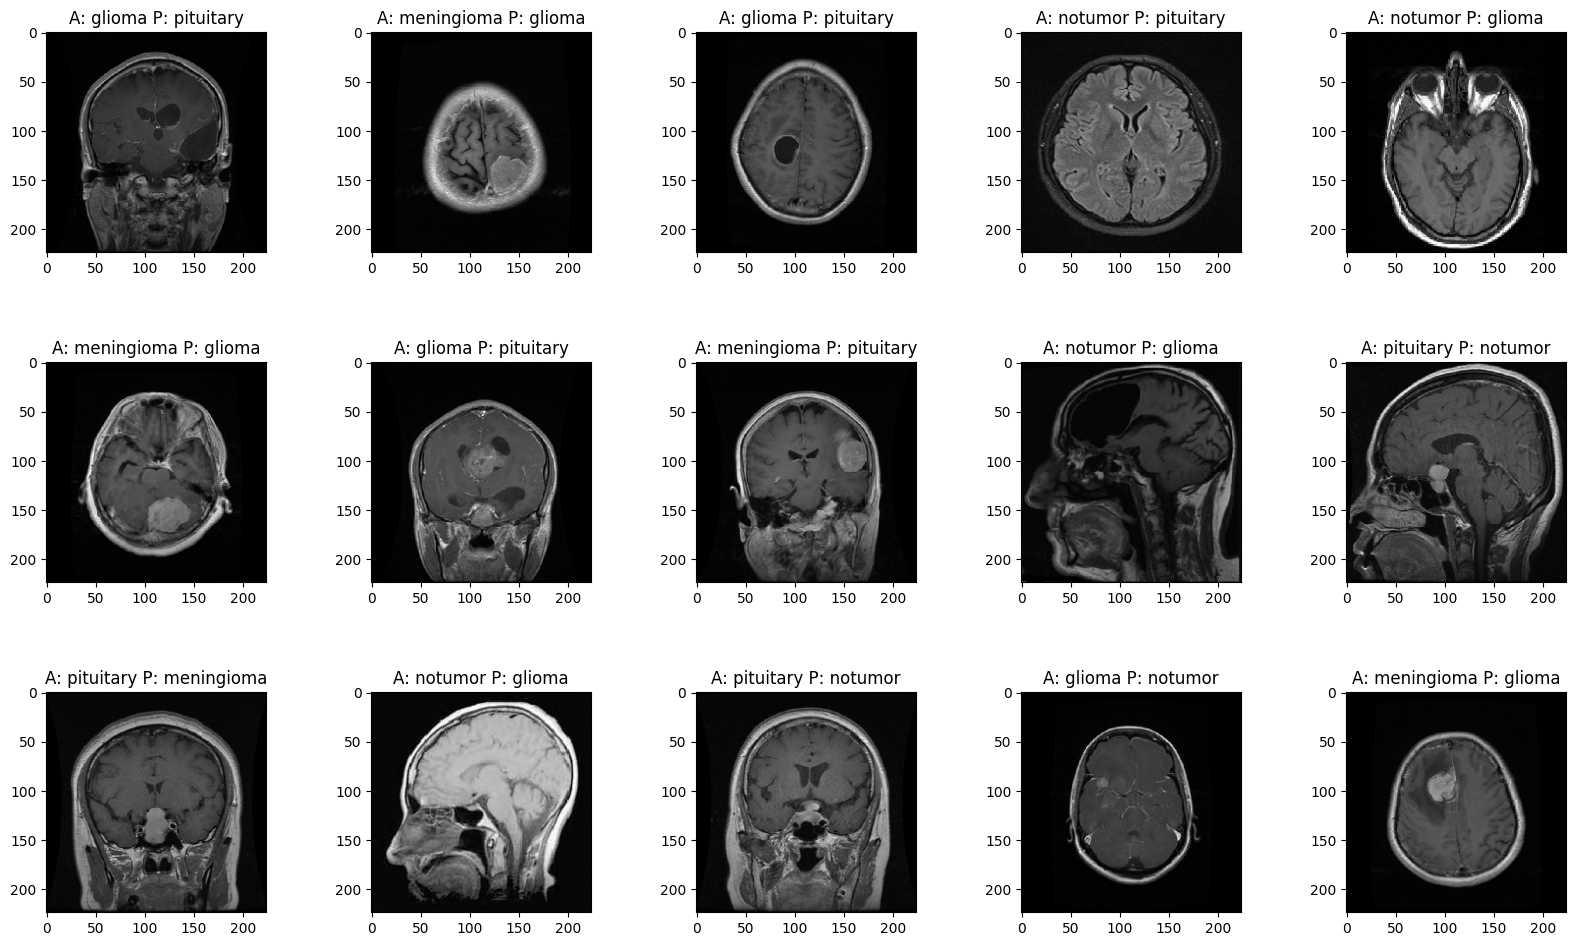

In [20]:
display_images(val_df[val_df['Same']!=True])

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- The fourth last layer of our model is the final convolutional block in our VGG-16 finetuned architecture
- Mean of the gradients is then multiplied to the last convolution layer's output 
- The output is then passed through a relu function to ensure that all values are positive

In [21]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [22]:
import matplotlib.cm as cm

In [23]:
val_df

filename      actual   predicted   Same
0        glioma\Tr-gl_0012.jpg      glioma   pituitary  False
1    meningioma\Tr-me_0164.jpg  meningioma      glioma  False
2        glioma\Tr-gl_0054.jpg      glioma   pituitary  False
3     notumor\Tr-noTr_0006.jpg     notumor   pituitary  False
4       notumor\Tr-no_0054.jpg     notumor     notumor   True
..                         ...         ...         ...    ...
772     notumor\Tr-no_0020.jpg     notumor   pituitary  False
773      glioma\Tr-gl_0159.jpg      glioma     notumor  False
774      glioma\Tr-gl_0081.jpg      glioma      glioma   True
775     notumor\Tr-no_0188.jpg     notumor     notumor   True
776      glioma\Tr-gl_0101.jpg      glioma  meningioma  False

[777 rows x 4 columns]

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [27]:
def gradCAMImage(image):
    path = f"./brain tumor/Training/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

## Results

In [28]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [ ]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

### Function to display heatmaps

In [30]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

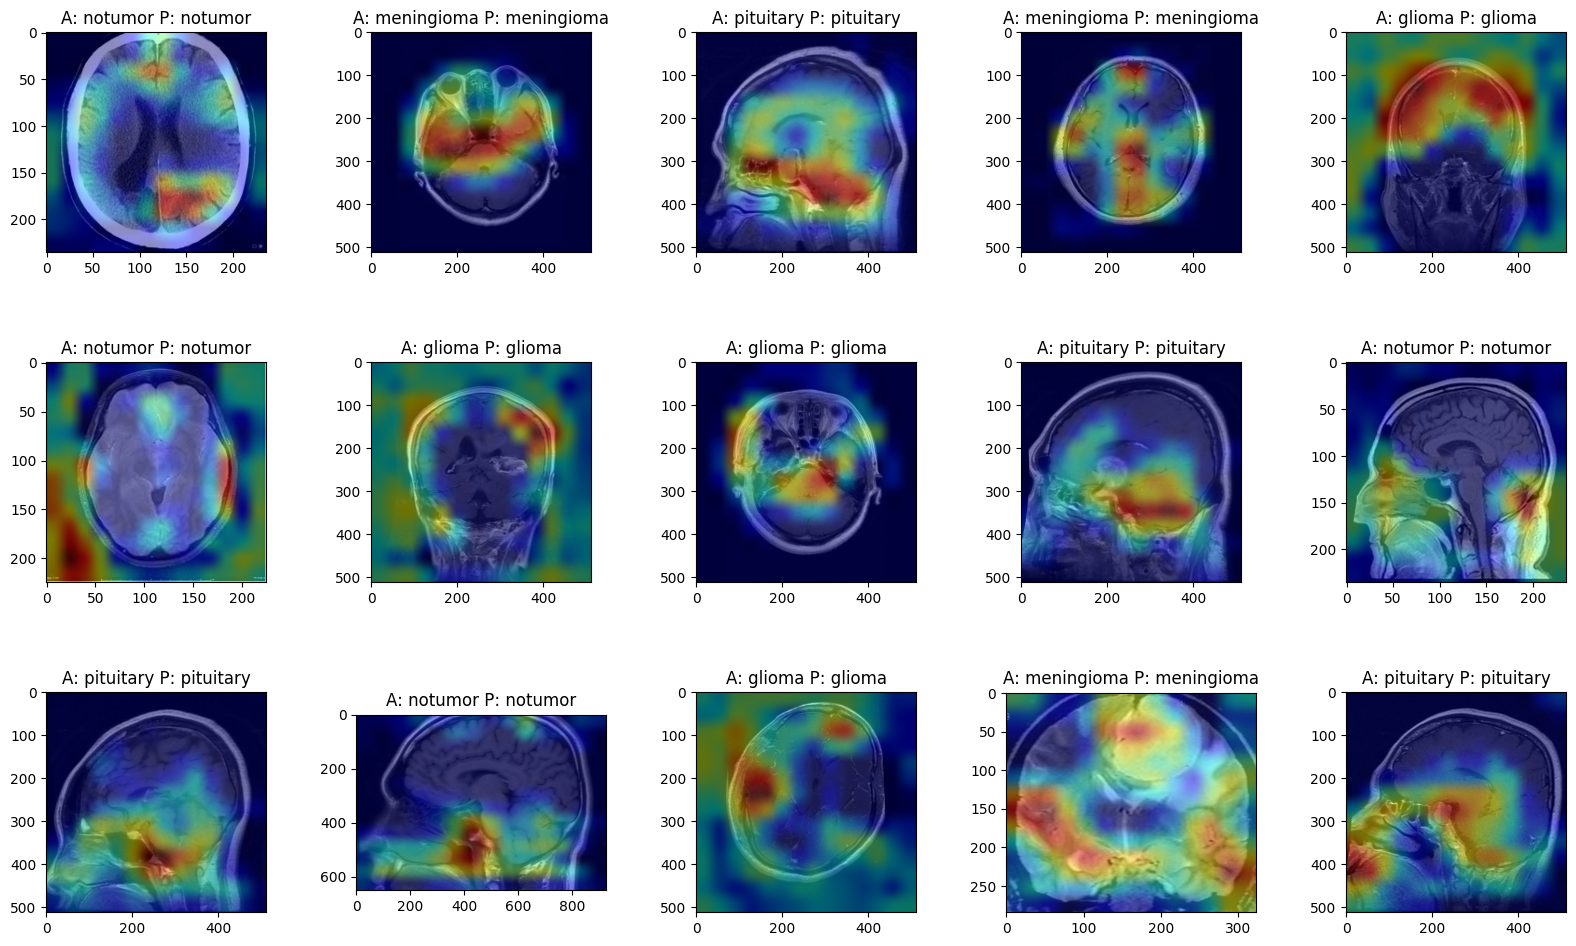

In [31]:
display_heatmaps(correctly_classified,c_titles)

**Inference:** As it can be seen some important features of the brain are highlighted in the image
- Pituitary Gland
- Meninges
- Glial cells position

### Grad-CAM: Incorrectly Classified

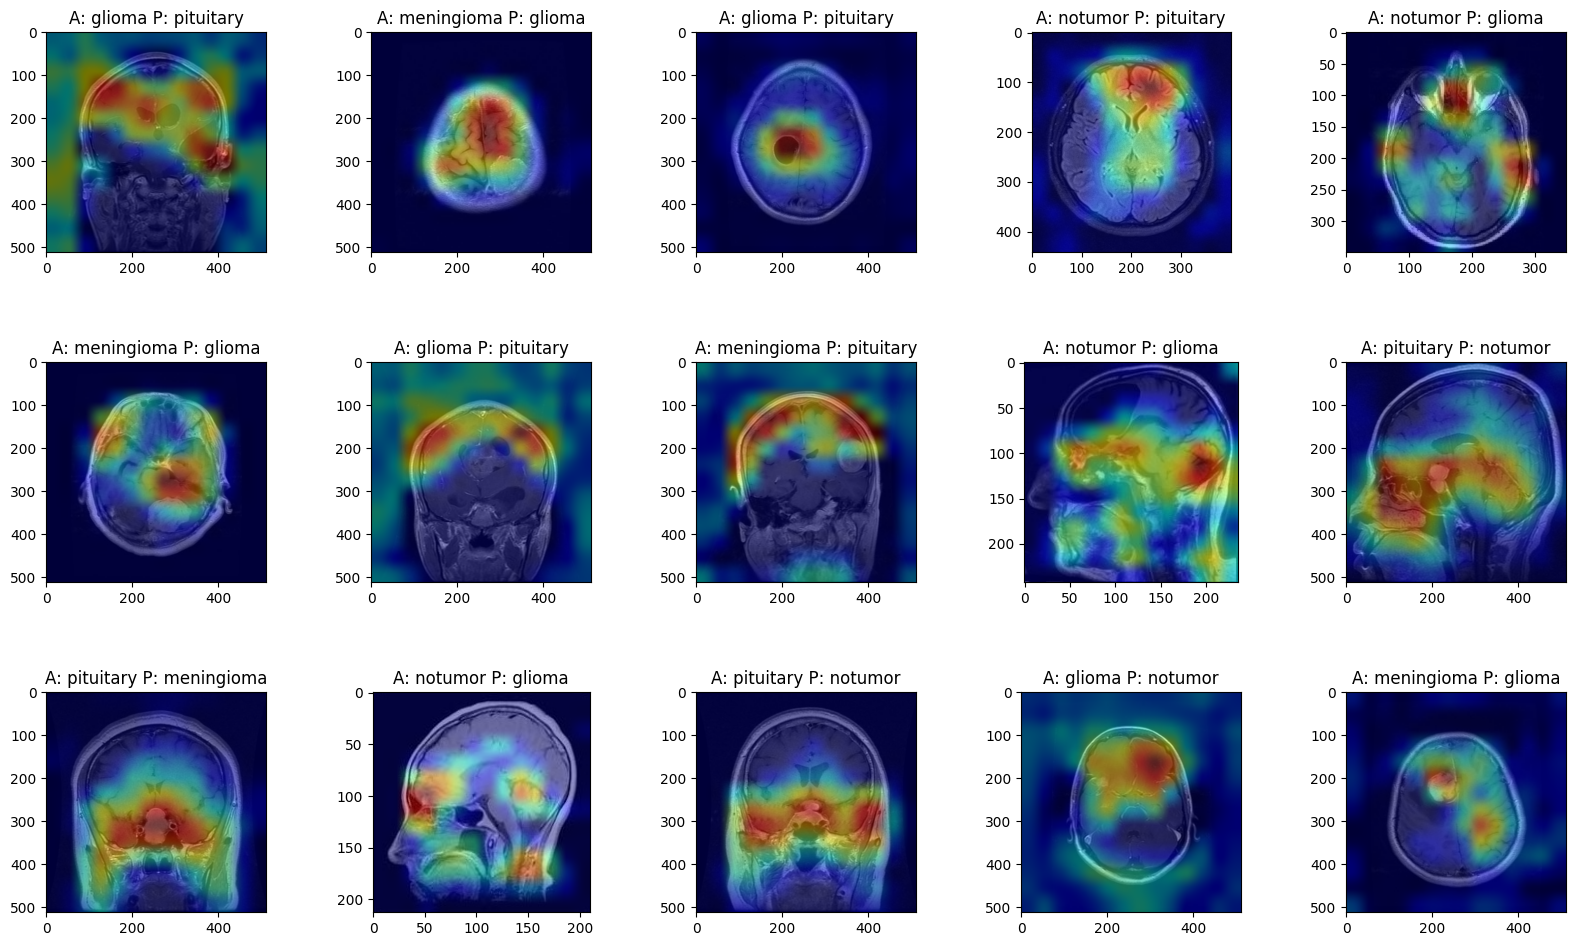

In [32]:
display_heatmaps(misclassified,m_titles)

**Inference:** As it can be seen some features have been incorrectly detected on some of these brain pictures either due to bad understanding of the struture:

- Goes hay wire with when there is No Tumor
- Difficulty in classifying Glioma and Pituitary
- Doesn't understand difference in Meningioma and Pituitary

These challenges can be resolved by using a better model or changing the augmentation pipeline.

## Conclusion

This project on Explainable AI for Brain Tumor Image Classification has been a fascinating journey. We have not only built models that can accurately classify brain tumor images but also delved into the reasoning behind these classifications.e

We used three different pre-trained models: **VGG16**, **ResNet50**, and **DenseNet121**. Each of these models brought their unique strengths to the table. However, **DenseNet121** outperformed the others, achieving an impressive accuracy of **90%**. This demonstrates the power of DenseNet's densely connected layers and efficient feature reuse.

### Future Work

While we achieved promising results, there is always room for improvement. Future work could explore other architectures, use larger or more diverse datasets, or delve deeper into the explainability aspect. 

Overall, this project underscores the importance of not just creating accurate AI models, but also making them explainable. As we continue to make strides in AI, let's ensure that transparency and interpretability remain at the forefront.